# NX31 Model Project

___
DELETE !

Notes, and things to remember before handing in!

- notes in parentheses
- ( lav docstrings til funktionerne! )
- (import packages - erase those we do not use)
___

# Introduction

We will examine the overlapping generations model (OLG), first the basic OLG model with consumption and savings, second will expand with two extensions, the pay as you go (PAYG) method and the fully funded (FF) method.
In the OLG model there is typical two generation, a generation working and a generation living on pension.
The PAYG is similar to state pension where the young generation pay a tax and this tax is used to fund the pension for the old generation and the FF model is more like a private pension savings account, where the young generation save for when they retire.

In [1]:
import numpy as np
import scipy as sp
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import sympy as sm
import math
import OLGModel

import numecon_linalg

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

## The General OLG model:

As mentioned, we start with our general OLG model with savings. This model looks as shown below.

Population growth or Labor growth:

\begin{eqnarray*}
L_t=(1+n) L_{t-1}
\end{eqnarray*}

Utility:

\begin{eqnarray*}
U_t=ln⁡(c_{1,t} )+ \frac{1}{(1+\rho)}ln⁡(c_{2,t+1} )
\end{eqnarray*}

Contraints:

\begin{eqnarray*}
ρ>-1
\end{eqnarray*}
\begin{eqnarray*}
c_{1,t}=w_t-s_t
\end{eqnarray*}
\begin{eqnarray*}
c_{2,t+1}=(1+r_{t+1} ) s_t
\end{eqnarray*}

where

- $L$ is population
- $n$ is the rate of population
- $U$ is lifetime utility
- $c_1$ is consumption as young
- $c_2$ is consumption as old
- $\rho$ is the discount rate
- $w$ is wage
- $s$ is savings
- $r$ is the interest rate

## Firm problem

The firms optimization will be the same in all extensions of the OLG model

Output function is given by:

\begin{eqnarray*}
F(K_t,L_t)=Y_t=A(K_t)^\alpha(L_t)^{1-\alpha}
\end{eqnarray*}

Profit function is given by:

\begin{eqnarray*}
\Pi(K_t,L_t)=F(K_t,L_t)-w_tL_t-(r_t+\delta)K_t
\end{eqnarray*}




- $Y$ is output
- $A$ is total factor productivity (TFP)
- $K$ is capital
- $L$ is population / labor force
- $\alpha$ is the share of capital
- $\Pi$ is profit
- $w$ is wage
- $r$ is the real interest rate
- $\delta$ is the degree of depreciation


We will check our results using the sympy package to make sure we have found the correct functions for the interest rate and wages.

In [2]:
sm.init_printing(use_unicode=True)

In [3]:
K = sm.symbols('K')
L = sm.symbols('L')
A = sm.symbols('A')
alpha = sm.symbols('alpha')
delta = sm.symbols('delta')
rho = sm.symbols('rho')
w = sm.symbols('w')
r = sm.symbols('r')
y = sm.symbols('y')
n = sm.symbols('n')
k = sm.symbols('k')
Pi = sm.symbols('Pi')

s = sm.symbols('s')
U = sm.symbols('U')
r_plus = sm.symbols('r_t+1')

In [4]:
Pi = A*(K**alpha)*(L**(1-alpha))-w*L-(r+delta)*K
print(Pi)
f1 = sm.diff(Pi,K)
f2 = sm.diff(Pi,L)
print(f1)
print(f2)
f1solve = sm.solve(A*K**alpha*L**(-alpha + 1)*alpha/K - delta - r, r)[0]
f2solve = sm.solve(A*K**alpha*L**(-alpha + 1)*(-alpha + 1)/L - w, w)[0]
print(f1solve)
print(f2solve)
print(f'r = (A*K**alpha*L*L**(-alpha)*alpha/K - delta)')
print(f'w = (-A*K**alpha*L**(-alpha)*(alpha - 1))')

A*K**alpha*L**(-alpha + 1) - K*(delta + r) - L*w
A*K**alpha*L**(-alpha + 1)*alpha/K - delta - r
A*K**alpha*L**(-alpha + 1)*(-alpha + 1)/L - w
A*K**alpha*L*L**(-alpha)*alpha/K - delta
-A*K**alpha*L**(-alpha)*(alpha - 1)
r = (A*K**alpha*L*L**(-alpha)*alpha/K - delta)
w = (-A*K**alpha*L**(-alpha)*(alpha - 1))


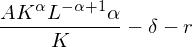

In [5]:
f1

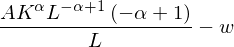

In [6]:
f2

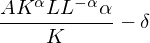

In [7]:
f1solve

In [8]:
f2solve

Now we define capital pr cap as $k$.
So the marginal products of capital and labor can be written as.
\begin{eqnarray*}
r_t = \alpha Ak_t^{\alpha-1}-\delta
\end{eqnarray*}

\begin{eqnarray*}
w_t = (1-\alpha) Ak_t^{\alpha}
\end{eqnarray*}

To find the steady state for capital pr capita, we will have to solve the household problem, by finding a expression for savings, $s$.

In [29]:
U = sm.log(w-s)+(1/(1+rho))*sm.log((1+r_plus)*s)
U_d = sm.diff(U,s)
u = sm.Eq(s,U_d)
print(u)
usolve = sm.solve(-1/(-s + w) + 1/(s*(rho + 1)),s)[0]
print(usolve)
print(f's = w/(rho + 2)')

Eq(s, -1/(-s + w) + 1/(s*(rho + 1)))
w/(rho + 2)
s = w/(rho + 2)


The aggregated solution in the OLG model is defined as
\begin{eqnarray*}
K_{t+1}=K_t (1-δ)+S_{1,t}+S_{2,t+1}, S_{2,t+1}≡-(1-δ) K_t=0	
\end{eqnarray*}
Because there are no savings in second period and we have assumed full depreciation we get
\begin{eqnarray*}
K_{t+1}=S_{1,t}=s_t L_t
\end{eqnarray*}
Now we set up the transition curve
\begin{eqnarray*}
\frac{K_{t+1}}{L_{t+1}} =k_{t+1}=s_t  \frac{L_t}{L_{t+1}} =s_t  \frac{L_t}{(L_t (1+n) )}=\frac{s_t}{(1+n)}=\frac{w_t}{(2+ρ)}  \frac{1}{(1+n)}=\frac{(1-α)Ak_t^α}{(2+ρ)(1+n)} 
\end{eqnarray*}

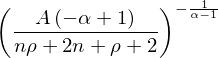

In [20]:
ss = sm.Eq(k,(((1-alpha)*A*(k**alpha))/((2+rho)*(1+n))))
kss = sm.solve(ss,k)[0]
kss

In [22]:
ss_func = sm.lambdify((alpha,n,rho,A),kss)

In [23]:
ss_func(1/3,0.02,0.04,1)

In [24]:
alpha_v = 1/3
n_v = 0.02
rho_v = 0.04
A_v = 1

In [25]:
obj_kss = lambda kss: kss - ((1-alpha_v)*A_v*(kss**alpha_v))/((2+rho_v)*(1+n_v))
result = optimize.root_scalar(obj_kss,bracket=[0.1,100],method='brentq')
result

      converged: True
           flag: 'converged'
 function_calls: 8
     iterations: 7
           root: 0.18135001783804428

## Interactive Figures

Below we plot the interactive figures showing the transition curve

In [31]:
# Transitions kurver
OLGModel.interactive_transition_curve()

interactive(children=(FloatSlider(value=0.33, continuous_update=False, description='$\\alpha$', max=0.99, min=…

# NOTES !

a: Guess on a k_ss, could be 1.6, or atleast lets start with that.
b: Calculate r_ss and w_ss
c: Solve the household problem
d: Calculate S (for the young)
e: k_sst (true) = s/1-n
f: Visualize your guesses


The true is the k_ss at the 45 degree line

g: k_sst-k_ss = 0

Tilbage til punkt a hvis nr. g ikke passer.

In [52]:
#a: Guess
k_ss = 0.18135001783804433
delta_v=1
r_ss = sm.symbols('r_ss')
w_ss = sm.symbols('w_ss')

def r(k,alpha,A,delta):
    return alpha*A*k**(alpha-1)-delta
def w(k,alpha,A):
    return (1-alpha)*A*k**alpha
def c1_gen(w,s):
    return w-s
def c2_gen(r,s):
    return (1+r)*s
def utility(c1,c2,rho_v):
    rho_v>-1
    return np.log(c1) + (1/(1+rho_v))*np.log(c2)

#b: Calculate r_ss and w_ss for guess
r_ss = r(k_ss,alpha_v,A_v,delta_v)
w_ss = w(k_ss,alpha_v,A_v)
print('Interest Rate Steady State: ',r_ss)
print('Wages Steady State: ',w_ss)

#c: Solve household problem
s_ss = w_ss/(2+rho_v)

print('Savings Steady State: ',s_ss)

c1 = c1_gen(w_ss,s_ss)
c2 = c2_gen(r_ss,s_ss)
util = utility(c1,c2,rho_v)
print('Consumption 1 Steady State: ', c1)
print('Consumption 2 Steady State: ', c2)
print('Utility Steady State: ', util)


k_sst = ((1-alpha_v)/((2+rho_v)*(1+n_v)))**(1/(1-alpha_v))
print(k_sst)

k_ss-k_sst == 0

Interest Rate Steady State:  0.04039999999999977
Wages Steady State:  0.3773531171174026
Savings Steady State:  0.1849770181948052
Consumption 1 Steady State:  0.1923760989225974
Consumption 2 Steady State:  0.1924500897298753
Utility Steady State:  -3.2328399292510155
0.18135001783804433


True

### functions 

In [15]:
def output(K,L,alpha,A):
    return A*(K**alpha)*(L**(1 - alpha))
def profit(output,w,L,r,K,delta=1):
    return output-w*L-(r+delta)*K

In [16]:
#Solving the general model gives:
def r(k,alpha,A,delta):
    return alpha*A*k**(alpha-1)-delta
def w(k,alpha,A):
    return (1-alpha)*A*k**alpha

PAYG OLG model

Utility...

\begin{eqnarray*}
U_t=ln⁡(c_{1,t} )+ \frac{1}{(1+\rho)}ln⁡(c_{2,t+1} )
\end{eqnarray*}

s.t.

\begin{eqnarray*}
ρ>-1
\end{eqnarray*}
\begin{eqnarray*}
c_{1,t}=w_t(1-d)-s_t
\end{eqnarray*}
\begin{eqnarray*}
c_{2,t+1}=(1+r_{t+1} ) s_t + w_{t+1}d(1+n)
\end{eqnarray*}

where

- $L$ is population
- $n$ is the rate of population
- $U$ is lifetime utility
- $c_1$ is consumption as young
- $c_2$ is consumption as old
- $\rho$ is the discount rate
- $w$ is wage
- $s$ is savings
- $r$ is the interest rate

In [ ]:
def c1_payg(w,s,d):
    return w(1-d)-s

def c2_payg(r,s,w,d,n):
    return (1+r)*s+wd(1+n)

d = 0.12

FF model

Utility...

\begin{eqnarray*}
U_t=ln⁡(c_{1,t} )+ \frac{1}{(1+\rho)}ln⁡(c_{2,t+1} )
\end{eqnarray*}

s.t.

\begin{eqnarray*}
ρ>-1
\end{eqnarray*}
\begin{eqnarray*}
c_{1,t}=w_t(1-\tau)-s_t
\end{eqnarray*}
\begin{eqnarray*}
c_{2,t+1}=(1+r_{t+1} ) s_t + \tau(1+r_{t+1})w_t
\end{eqnarray*}

where

- $L$ is population
- $n$ is the rate of population
- $U$ is lifetime utility
- $c_1$ is consumption as young
- $c_2$ is consumption as old
- $\rho$ is the discount rate
- $w$ is wage
- $s$ is savings
- $r$ is the interest rate

In [ ]:
def c1_ff(w,s,tau):
    return w(1-tau)-s

def c2_ff(r,s,tau,w):
    return (1+r)*s+tau*(1+r)*w

tau = 0.13

In [ ]:
def c1_gen(w,s):
    return w-s

def c2_gen(r,s):
    return (1+r)*s

def utility(c1,c2,rho):
    rho>-1
    return np.log(c1)+(1/(1+rho))*np.log(c2)